# Urban area mapping using image thresholding

* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc), 

> **_NOTE:_** Please run this notebook using the the Large Environment with 4 cores and 32 GB Memory.

## Background

Image thresholding is one of the simplest techniques used in land cover and land use classifications. 


## Description

This notebook will demonstrate how to use Multi-Otsu Thresholding to classify land as 'urban' from Sentinel 1 data then compare those results with the ESA WorldCover global land cover product for the year 2020.

This notebook contains the following steps:

1. Select a location and time range  for the analysis.
2. Load VV polarization Sentinel-1 backscatter data for the area of interest. 
3. Convert the digital numbers to dB values for analysis.
4. Generate a median VV polarization composite image from the Sentinel 1 data.
5. Perform Multi-Otsu thresholding on the median composite image.
6. Show the Multi-Otsu thresholding urbanization prediction images
7. Load and show the "ground truth" ESA Worldcover data for the year 2020.
8. Compare the urbanization prediction with the "ground truth" data visually and statistically.

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
# Uncomment the line below to install the tabulate module.
# !pip install tabulate

In [2]:
# Load the necessary packages.

%matplotlib inline

import warnings
import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolours
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tabulate import tabulate

warnings.filterwarnings("ignore")

from skimage.filters import threshold_multiotsu
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    cohen_kappa_score,
    confusion_matrix,
)

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, plot_lulc
from deafrica_tools.classification import sklearn_flatten

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app="Urban_area_mapping")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis.
The parameters are:
* `central_lat`: The central latitude of the area of interest to analyse.
* `central_lon`: The central longitude of the area of interest to analyse.
* `buffer`: The number of square degrees to load around the central latitude and longitude. 
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The time range for your analysis, e.g.`('2020')` if you wanted data from all of 2020.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers part of  Nairobi County, Kenya.

In [4]:
# Define the area of interest.
central_lat = -1.2933
central_lon = 36.8679

lat_buffer = 0.1
lon_buffer = 0.1

# Combine lat, lon with their respective buffers to get area of interest.
lat_range = (central_lat - lat_buffer, central_lat + lat_buffer)
lon_range = (central_lon - lon_buffer, central_lon + lon_buffer)

# Time frame for the analysis.
time_range = "2020"

### View the selected location

The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
# View the study area
display_map(x=lon_range, y=lat_range)

## Load and view the Sentinel-1 data

### Load the Sentinel 1 data
The first step in the analysis is to load the VV polarization Sentinel-1 backscatter data for the specified area of interest.
This uses the pre-defined [load_ard](../Frequently_used_code/Using_load_ard.ipynb) utility function. 
The `load_ard` function is used here to load an analysis ready dataset free of shadow, and missing data.

In [6]:
ds = load_ard(
    dc=dc,
    products=["s1_rtc"],
    measurements=["vv"],
    y=lat_range,
    x=lon_range,
    time=time_range,
    output_crs="EPSG:6933",
    resolution=(-10, 10),
    group_by="solar_day",
)

print(ds)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 89 time steps
<xarray.Dataset>
Dimensions:      (time: 89, y: 2551, x: 1931)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T15:56:20.113636 ... 2020-12...
  * y            (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05 -1.777e+05
  * x            (x) float64 3.548e+06 3.548e+06 ... 3.567e+06 3.567e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 0.3886 0.3886 0.09932 ... 0.06189 0.03677
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


### View the Sentinel 1 data

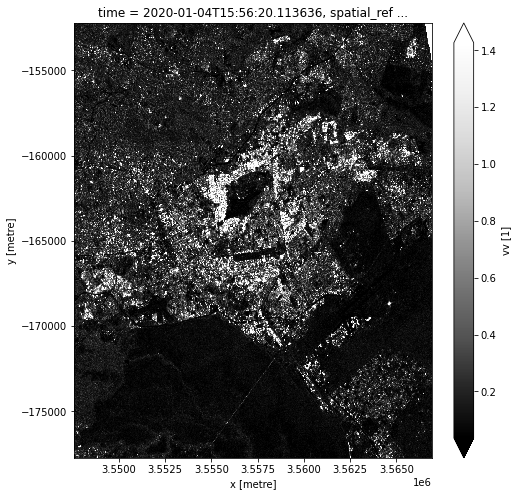

In [7]:
# Plot the first VV observation for the year 2020.
ds.vv.isel(time=0).plot(cmap="Greys_r", robust=True, figsize=(8, 8))

## Convert the Digital Numbers (DN) values to Decibel values (dB)

The Sentinel-1 backscatter data is provided as digital number (DN), which can be converted to backscatter in decibel unit (dB) using the function:

\begin{equation}
10 * \log_{10}(\text{DN})
\end{equation}


It is often useful to convert the backscatter to decible (dB) for analysis because the backscatter in dB unit has a more symmetric noise profile and less skewed value distribution for easier statistical evaluation.

In [8]:
# Convert DN to db values.
ds["vv_db"] = 10 * xr.ufuncs.log10(ds.vv)

## Generate a median value composite image
We will combine all the VV observations in our Sentinel 1 `ds` `xarray.Dataset` into a single, complete (or near complete) image representing the median of the time period.

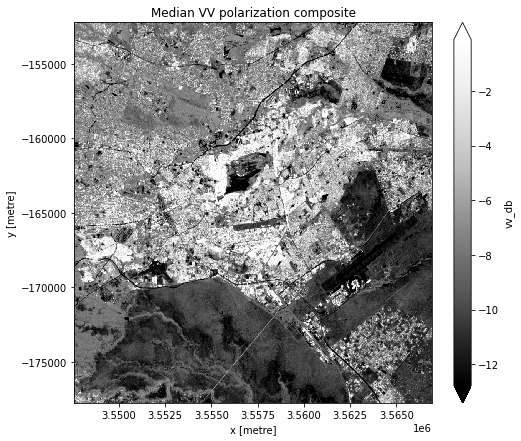

In [9]:
# Obtain the median of all VV observations for the time period.
median_vv = ds.vv_db.median(dim="time")

# Plot the median VV polarization composite.
fig = plt.figure(figsize=(8, 7))
median_vv.plot(cmap="Greys_r", robust=True)
plt.title("Median VV polarization composite");

## Classification using Muti-Otsu thresholding

> **_NOTE:_**, You can use the scikit-image `skimage.filters.try_all_threshold` function to evaluate different thresholding algorithms in order to select the best threshold algorithm.

In [10]:
# Convert the VV polarization median composite Data Array into a numpy array.
image = median_vv.data

In [11]:
# Applying Multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)

In next two cells below,  we will visualize the results from applying the Multi-Otsu threshold.

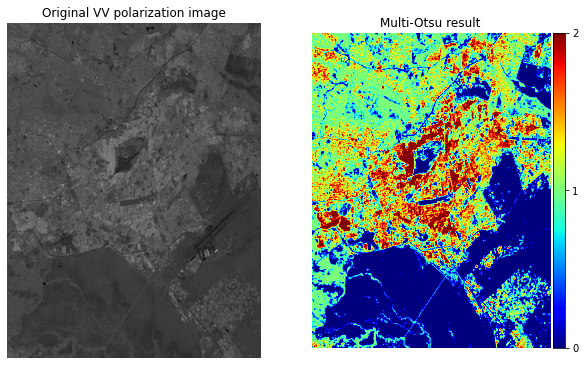

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

# Plotting the original image.
ax[0].imshow(image, cmap="gray")
ax[0].set_title("Original VV polarization image")
ax[0].axis("off")

# Plotting the Multi Otsu result.
im = ax[1].imshow(regions, cmap="jet")
ax[1].set_title("Multi-Otsu result")
ax[1].axis("off")
## Customise the colourbar.
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax, orientation="vertical")
cbar.set_ticks(np.unique(regions))
cbar.set_ticklabels(np.unique(regions))

plt.subplots_adjust()

plt.show()

From the plot above, the most likely pixel value in the `regions` numpy array to represent urban land cover is the value `2`. 

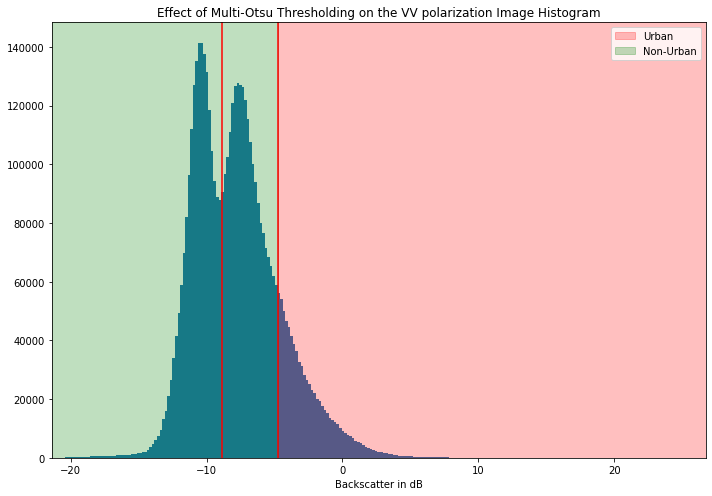

In [13]:
# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(image.ravel(), bins=255)
ax.axis(xmin=image.min(), xmax=image.max())
ax.axvspan(xmin=thresholds[1], xmax=image.max(), alpha=0.25, color="red", label="Urban")
ax.axvspan(
    xmin=image.min(), xmax=thresholds[1], alpha=0.25, color="green", label="Non-Urban"
)
ax.set_title("Effect of Multi-Otsu Thresholding on the VV polarization Image Histogram")
ax.set_xlabel("Backscatter in dB")
for thresh in thresholds:
    ax.axvline(thresh, color="r")
plt.legend()
plt.tight_layout()

In [14]:
# Define the classified image.
classified = regions == 2

# Replace the values True and False with 1 and 0 respectively in the binary_vv numpy array.
repl_dict = {True: 1, False: 0}

input_array = classified

out = np.zeros(input_array.shape, dtype=np.int16)

for key in repl_dict:
    out[input_array == key] = repl_dict[key]

classified = out

In [15]:
# Convert the classified numpy array into an xarray Dataset.
thresholding_predicted_ds = xr.Dataset(
    data_vars=dict(
        thresholding_predicted=(["y", "x"], classified),
    ),
    coords=dict(
        y=(["y"], ds.coords["y"].values),
        x=(["x"], ds.coords["x"].values),
        spatial_ref=ds.coords["spatial_ref"].values,
    ),
    attrs=ds.attrs,
)

print(thresholding_predicted_ds)

<xarray.Dataset>
Dimensions:                 (y: 2551, x: 1931)
Coordinates:
  * y                       (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05
  * x                       (x) float64 3.548e+06 3.548e+06 ... 3.567e+06
    spatial_ref             int32 6933
Data variables:
    thresholding_predicted  (y, x) int16 1 1 0 0 0 0 1 1 0 ... 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In the `thresholding_predicted_ds` xarray Dataset the pixel value `1` is urban land cover and `0` for non-urban land cover.

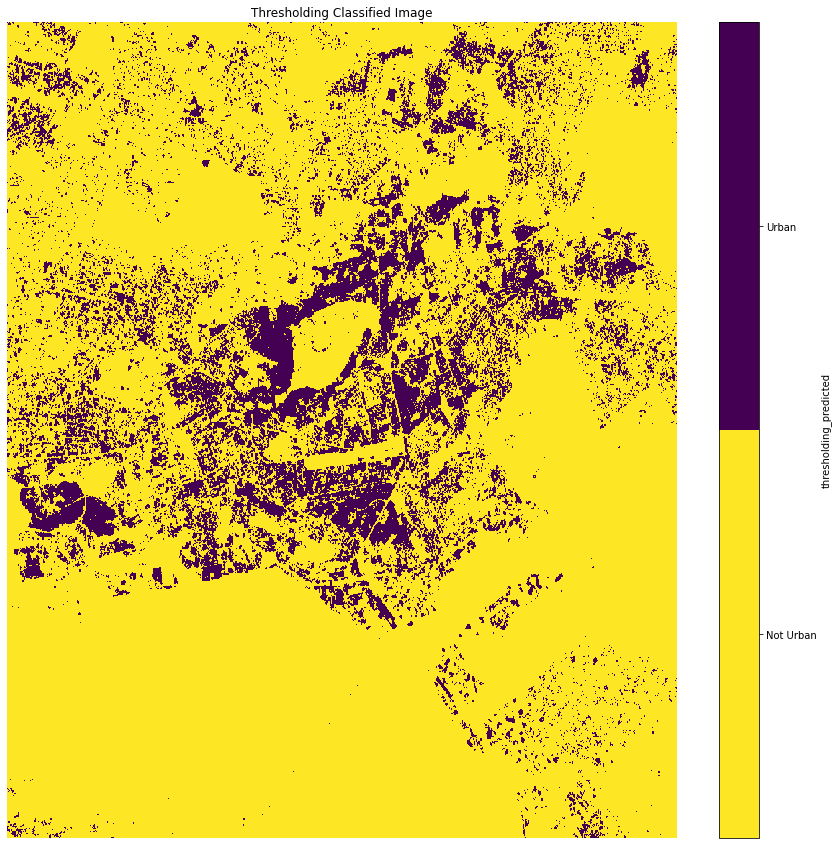

In [16]:
image = thresholding_predicted_ds["thresholding_predicted"]
no_classes = 2
colour_list = ["#fde725", "#440154"]
cmap = mcolours.ListedColormap(colour_list)
bounds = range(0, no_classes + 1)
norm = mcolours.BoundaryNorm(np.array(bounds), cmap.N)
cblabels = ["Not Urban", "Urban"]
im = image.plot.imshow(cmap=cmap, norm=norm, add_colorbar=True, figsize=(15, 15))
cb = im.colorbar
cb.set_ticks(np.arange(0, no_classes + 1, 1) + 0.5)
cb.set_ticklabels(cblabels)
plt.axis("off")
plt.title("Thresholding Classified Image")
plt.show()

## Validation of the threhsolding classification
We will compare the performance of the urban area Multi-Otsu thresholding classification results against a built area (urban area) map for the study area derived from the ESA World Cover, global 10 m land use/land cover data from 2020. 

### Obtain the validation dataset

In [17]:
# Load the ESA land use land cover product over the same region as the Sentinel 1 dataset.
ds_esa = dc.load(product="esa_worldcover", like=ds.geobox).squeeze()

# Pixels with a value of 50 are classified as built up land cover.
# Mask the ESA land cover dataset to retain only pixels with the value 50.
actual = ds_esa["classification"] == 50

# Replace the values True and False with 1 and 0 respectively.
repl_dict = {True: 1, False: 0}

input_array = actual.values

out = np.zeros(input_array.shape, dtype=np.int16)

for key in repl_dict:
    out[input_array == key] = repl_dict[key]

actual.values = out

print(actual)

<xarray.DataArray 'classification' (y: 2551, x: 1931)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)
Coordinates:
    time         datetime64[ns] 2020-07-01T12:00:00
  * y            (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05 -1.777e+05
  * x            (x) float64 3.548e+06 3.548e+06 ... 3.567e+06 3.567e+06
    spatial_ref  int32 6933


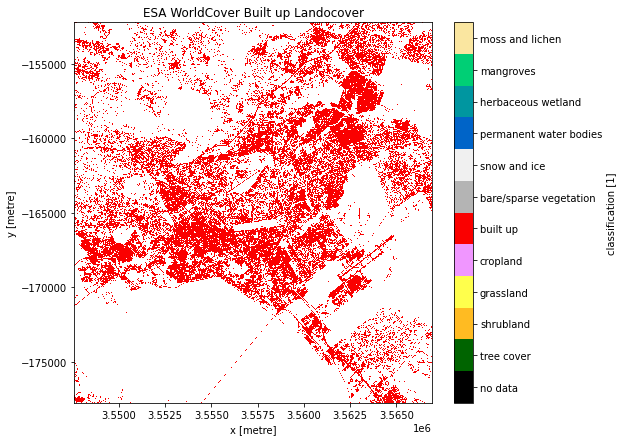

In [18]:
# Plot the built up land cover from the ESA worldcover dataset.
built_up = ds_esa.where(ds_esa["classification"] == 50)
plot_lulc(built_up["classification"], product="ESA", legend=True, figsize=(8, 7))
plt.title("ESA WorldCover Built up Landocover");

### Metric and Plotting Functions
We will use functions from the `sklearn.metrics` module to evaluate the classification.
Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. 

$$
\begin{aligned}
\text{Overall Accuracy (OA)} = \frac{\text{True Positive} + \text{True Negative}}{\text{Total Pixels}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Producer's Accuracy (PA) or Precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}
\end{aligned}
$$

$$
\begin{aligned}
\text{User's accuracy (UA) or  Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}
\end{aligned}
$$

$$
\begin{aligned}
\text{F1 Score} = 2*\frac{\text{Recall}*\text{Precision}}{\text{Recall} + \text{Precision}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Kappa  } \kappa = (p_o - p_e) / (1 - p_e)
\end{aligned}
$$

In [19]:
# Metrics for Multi-Otsu thresholding.
y_true = sklearn_flatten(actual)
y_pred = sklearn_flatten(thresholding_predicted_ds[['thresholding_predicted']])


# Producer's Accuracies.
precision = precision_score(y_true, y_pred, labels=[0,1], average=None)
urban_precision = precision[1] * 100
non_urban_precision = precision[0] * 100

# User's Accuracies.
recall = recall_score(y_true, y_pred, labels=[0,1], average=None)
urban_recall = recall[1] * 100
non_urban_recall = recall[0] * 100

# Overall Accuracy.
accuracy = accuracy_score(y_true, y_pred, normalize=True)
overall_accuracy = accuracy * 100

# Micro-averaged F1 score.
f1score = f1_score(y_true, y_pred, average='micro')  * 100

# Kappa coefficient.
kappa = cohen_kappa_score(y_true, y_pred)

print("\033[1m" + "\033[91m" + "Urban Area Mapping Results")  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: \t\t", round(overall_accuracy, 3))
print("Micro-averaged F1 score: \t", round(f1score, 3))
print("Kappa coefficient: \t\t", round(kappa, 3))
print("")
table1 = [("Producer's Accuracy", round(urban_precision, 3), round(non_urban_precision, 3)),
          ("User's Accuracy", round(urban_recall, 3), round(non_urban_recall, 3))]
print(tabulate(table1, stralign='left', headers=( "","Urban", "Non-urban")))

Urban Area Mapping Results

Overall Accuracy: 		 79.136
Micro-averaged F1 score: 	 79.136
Kappa coefficient: 		 0.388

                       Urban    Non-urban
-------------------  -------  -----------
Producer's Accuracy   67.641       81.338
User's Accuracy       40.987       92.917


The `dstack` calls provide the `imshow` calls with RGB array inputs. 
For the plotted image, the first channel (red) is the actual (ground truth, ESA Worldcover) values, and both the second and third channels (green, blue) are the predicted values (green + blue = cyan).

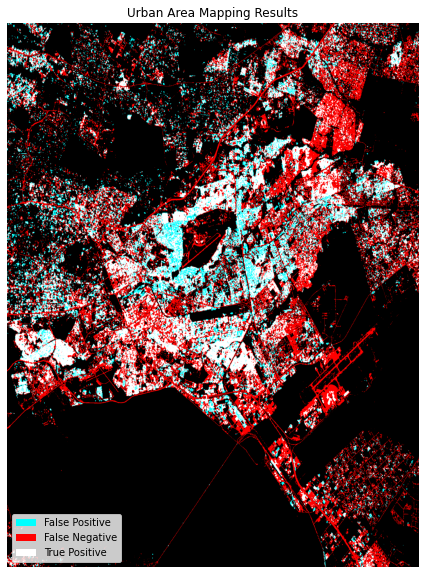

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(
    np.dstack(
        (
            actual.data.astype(float),
            thresholding_predicted_ds.thresholding_predicted.data.astype(float),
            thresholding_predicted_ds.thresholding_predicted.data.astype(float),
        )
    )
)
plt.legend(
    [Patch(facecolor="cyan"), Patch(facecolor="red"), Patch(facecolor="white")],
    ["False Positive", "False Negative", "True Positive"],
    loc="lower left",
    fontsize=10,
)
plt.axis("off")
plt.title("Urban Area Mapping Results");

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [21]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [22]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-11-27'